<a href="https://colab.research.google.com/github/mtsilimos/Codesnippets_Sentence-Embeddings-for-the-Classification-of-Explicit-Fine-grained-Discourse-Relations/blob/main/gloveearlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import pandas as pd

df1 = pd.read_csv('/content/drive/My Drive/finalcorpus.csv', ';', encoding= 'unicode_escape')

<ipython-input-96-bed78225ebf4>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df1 = pd.read_csv('/content/drive/My Drive/finalcorpus.csv', ';', encoding= 'unicode_escape')


In [97]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [98]:
X = df1['text']
y = df1['label']

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20, random_state=42)

In [100]:
vocab_size = 20000
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"

In [101]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [102]:
word_index = tokenizer.word_index

In [103]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

In [104]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,
                       truncating=trunction_type)

In [105]:
X_train_padded.shape

(1600, 100)

In [106]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)

In [107]:
X_test_padded.shape

(400, 100)

In [108]:
embeddings_index = {}
f = open('/content/drive/My Drive//glove.twitter.27B.100d.txt', encoding="utf8")
for line in f:
         values = line.split()
         word = values[0]
         coefs = np.asarray(values[1:], dtype='float32')
         embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [109]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [110]:
embedding_matrix.shape

(4499, 100)

In [111]:
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [112]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=0,
    min_delta=0.001,
    mode='max'
)


model = Sequential()
embedding_dim = 32
input_length = 50
model = Sequential([
    embedding_layer,
  Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Dense(20,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='relu'),
    Dropout(0.5),
  Dense(1,activation='sigmoid')
])



METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)



print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          449900    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 64)           34048     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 100, 20)           1300      
                                                                 
 dropout_12 (Dropout)        (None, 100, 20)           0         
                                                                 
 dense_17 (Dense)            (None, 100, 6)            126       
                                                                 
 dropout_13 (Dropout)        (None, 100, 6)            0         
                                                      

In [113]:
history = model.fit(X_train_padded, y_train, epochs=10, shuffle = True, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

Epoch 1/10
25/25 [==============================] - 7s 131ms/step - loss: 0.6950 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/10
25/25 [==============================] - 3s 143ms/step - loss: 0.6925 - accuracy: 0.4989 - val_loss: 0.6923 - val_accuracy: 0.5266
Epoch 3/10
25/25 [==============================] - 3s 117ms/step - loss: 0.6851 - accuracy: 0.5468 - val_loss: 0.6535 - val_accuracy: 0.8137
Epoch 4/10
25/25 [==============================] - 2s 93ms/step - loss: 0.6389 - accuracy: 0.6880 - val_loss: 0.5979 - val_accuracy: 0.8144


In [114]:
model.evaluate(X_test_padded, y_test)

13/13 [==============================] - 0s 21ms/step - loss: 0.5979 - accuracy: 0.8144


[0.5979446172714233, 0.8143749833106995]

In [115]:
model.evaluate(X_train_padded, y_train)

50/50 [==============================] - 1s 27ms/step - loss: 0.5990 - accuracy: 0.8094


[0.5990279316902161, 0.8094000220298767]

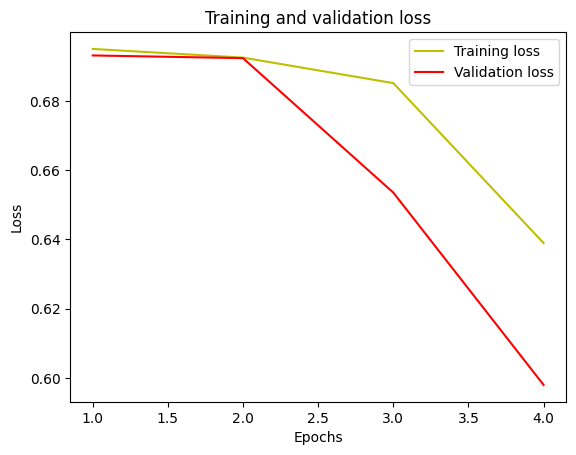

In [116]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

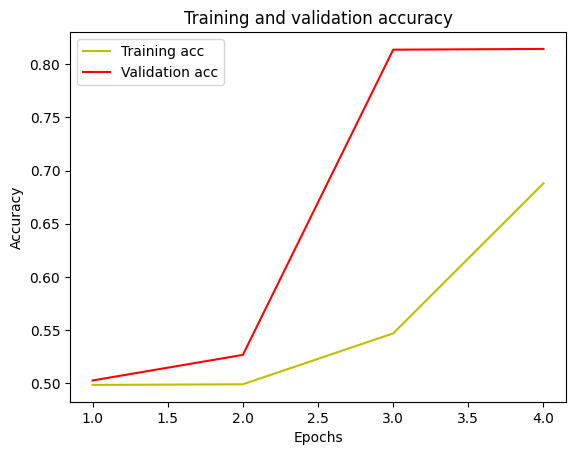

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:


model.evaluate(X_test, y_test)

UnimplementedError: ignored